## MACHINE LEARNING METHOD for DAZZLED CAMERAS RECOGNITION

### 1. SIMULATED DATA - PREPROCESSING

> Here I import the libraries I will need after.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

> List of the files that contain simulated data 

In [2]:
sim_file_list = ["./data/data1/response1.npy", "./data/data2/response2.npy"]

> The **DimensionsData** function summarizes useful characteristics of the file given as input.<br>
> The **load** function loads a _numpy_ file with simulated data. It takes as input the name of the file and it returns a matrix EVENTS(rows)xCAMERAS(cols). It is formed by 32x32 matrices, where each element is the number of photons that hit a pixel. This number isn't an integer since it is extracted from the electronic signal.

In [3]:
def DimensionsData(fname):
    file = np.load(fname)#mettere np.load
    nr_events = len(file)
    nr_pixels = len(file[0][0])
    nr_cams = len(file[0])
    nr_tot_events = nr_cams*nr_events
    return nr_events, nr_pixels, nr_cams, nr_tot_events

> **Preprocessing function**<br>It preprocesses simulated data, taking in input the name of the file we want to preprocess and returns as output an array with all the cameras of all the events. So it will be long as the number of the events and each element is a matrix 32x32. This is important since these data has to be consistent with the labels format.

In [4]:
def Preprocessing(fname):
    file = np.load(fname)
    nr_events, nr_pixels, nr_cams, _ = DimensionsData(fname)
    all_sim_data = file.reshape(nr_events*nr_cams, nr_pixels, nr_pixels)
    return all_sim_data

### 2. ROOT "TRUE" DATA - ROOTPREPROCESSING

> List of files that contain the truth relative to the simulated data I loaded before. They originally are in _ROOT_ format, thus explaining the recurring of "root" prefix in the following notation, and also to distinguish these files from the simulated ones. From these data I will extract the labels needed from the neural network.

In [5]:
root_file_list = ["./data/data1/sensors1.npy", "./data/data2/sensors2.npy"]

> **load_root function**<br>It takes in input the name of the _numpy_ file with the MC truth. Then it arranges the data of inner photons in a matrix of dimensions EVENTS(rows)xCAMERAS(cols), where each element is the number of inner photons.

In [6]:
def load_root(root_fname):
    root_file_tr = np.load(root_fname)
    root_file = root_file_tr.transpose()
    return root_file

> The **InitializeDatasetParameter** function to gather all parameters I use in preparing the dataset.

In [7]:
def InitializeDatasetParameters():
    ratio_thr = 0.1
    sum_thr = 40
    return ratio_thr, sum_thr

ratio_thr, sum_thr = InitializeDatasetParameters()

> The **SumPhotons** function that takes in input the name of _drdf_ file and that returns the sum of the photons in each camera in that file.

In [8]:
def SumPhotons(fname):
    tot_photons = []
    all_sim_data = Preprocessing(fname)
    for data in all_sim_data:
        sum_ph = np.sum(data)
        tot_photons.append(sum_ph)
    return tot_photons

> The **RootPreprocessing** function that takes in input the names of the _drdf_ and _ROOT_ file and that returns an array with the "state" of the camera (i.e. 0 if not-dazzled, 1 if dazzled). The label criterion is if $\frac{N_{inner photons}}{N_{tot photons}} > 0.1$ then the camera is dazzled. To see more details about the choice of this criterion consult the README.md.

In [9]:
def RootPreprocessing(root_fname,fname):
    root_file = load_root(root_fname)
    inner_photons_list = root_file.flatten()
    tot_photons = SumPhotons(fname)
    
    labels = []
    for i in range(len(inner_photons_list)):
        np.seterr(divide='ignore', invalid='ignore')
        ratio = inner_photons_list[i]/tot_photons[i]
        if ratio >= ratio_thr:
            value = 1
        elif ratio < ratio_thr:
            value = 0
        labels.append(value)
    labels = np.asarray(labels)
    return labels

def RootPreprocessing2(root_fname,fname):
    root_file = load_root(root_fname)
    inner_photons_list = root_file.flatten()
    tot_photons = SumPhotons(fname)
    
    labels = []
    for i, inner_ph in enumerate(inner_photons_list):
        np.seterr(divide='ignore', invalid='ignore')
        ratio = inner_ph/tot_photons[i]
        if ratio >= ratio_thr:
            value = 1
        elif ratio < ratio_thr:
            value = 0
        labels.append(value)
    labels = np.asarray(labels)
    return labels

### 3. DATA REARRANGEMENT

> Here I import libraries I need in this section.

In [10]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.model_selection import train_test_split

> The **Cut** function takes in input the lists of simulated and _ROOT_ files. Its aim is to find the cameras with less than a certain threshold of total photons detected. It returns three objects: 
> - *index_to_cut*: list that contains the indices of the number of the events that respect this condition.
> - *all_images* and *root_images*: arrays that contain all the simulated _drdf_ and _ROOT_ events. 

In [11]:
def Cut(root_fname: list, fname: list):

    all_sim_data = np.concatenate([Preprocessing(f) for f in fname]) 
    root_labels = np.concatenate([RootPreprocessing(root_fname[i],fname[i]) for i in range(len(fname))]) 

    indices_to_cut = []
    i = 0
    for data in all_sim_data:
        if np.sum(data)<sum_thr:
            indices_to_cut.append(i)
        i += 1
    return indices_to_cut, all_sim_data, root_labels

> The **DatasetCut** function takes in input the lists of simulated and _ROOT_ files. It returns two arrays that are *all_images* and *root_labels* without the events cut.

In [12]:
def DatasetCut(root_fname: list, fname: list):
    index_to_cut, all_sim_data, root_labels = Cut(root_fname, fname)
    all_sim_data_list = list(all_sim_data)
    root_labels_list = list(root_labels)
    
    for i in sorted(index_to_cut, reverse=True):
        del all_sim_data_list[i], root_labels_list[i]

    data_cut = np.array(all_sim_data_list)
    root_labels_cut = np.array(root_labels_list)

    data_cut = data_cut.reshape(data_cut.shape[0],32,32,1)

    return data_cut, root_labels_cut

> The **PrepareData** function splits the dataset in three sub-datasets, using twice the *train_test_split* function: 
> - train_ds: 72% of the dataset cut
> - val_ds: 18% of the dataset cut
> - test_ds: 10% of the dataset cut<br>
>
> and returns all these sub-datasets (arrays of matrices) with the respective labels (arrays of numbers 0/1). 

In [13]:
def PrepareData(root_fname: list, fname: list):
    data_cut, root_labels_cut = DatasetCut(root_fname, fname)
    t_ds, test_ds, t_labels, test_labels = train_test_split(data_cut, root_labels_cut, train_size=0.9, random_state=42)
    train_ds, val_ds, train_labels, val_labels = train_test_split(t_ds, t_labels, train_size=0.85, random_state=42)

    train_ds = np.asarray(train_ds)
    val_ds = np.asarray(val_ds)
    test_ds = np.asarray(test_ds)

    train_ds = train_ds.reshape(train_ds.shape[0], 32, 32,1)
    val_ds = val_ds.reshape(val_ds.shape[0], 32, 32, 1)
    test_ds = test_ds.reshape(test_ds.shape[0],32,32,1)

    return train_ds, val_ds, test_ds, train_labels, val_labels, test_labels

> The **FindDazzledCameras** function takes in input two arrays, the first of labels and the second of simulated data. It returns: 
> - *ev_dazzled_cameras*: list that contains the number of events that correspondes to dazzled cameras
> - *dazzled_cameras*: list that contains the dazzled cameras

In [14]:
def FindDazzledCameras(labels,sim_data):
    i = 0
    ev_dazzled_cameras = []
    dazzled_cameras = []
    for l in labels:
        if l == 1:
            ev_dazzled_cameras.append(i)
        i+=1
    for i in ev_dazzled_cameras:
        dazzled_cameras.append(sim_data[i])
    return ev_dazzled_cameras, dazzled_cameras

> The **Augmentation** function takes in input two arrays, the first of labels and the second of simulated data. It returns: 
> - *augmented_ds*: array that contains the images to add
> - *augmented_labels*: array that contains the respective labels

In [15]:
def Augmentation(labels, sim_data):
    input_shape = [32,32,32,1]
    data_augmentation = keras.Sequential()
    data_augmentation.add(layers.RandomFlip("horizontal", input_shape=input_shape[1:]))
    data_augmentation.add(layers.RandomFlip("vertical"))
    data_augmentation.add(layers.RandomRotation(0.2))
    
    _, dazzled_cameras = FindDazzledCameras(labels,sim_data)

    augmented_ds = []
    for camera in dazzled_cameras:
        for i in range(150):
            augmented_image = data_augmentation(camera)
            augmented_image_sq = np.squeeze(augmented_image, axis=3)
            augmented_ds.append(augmented_image_sq)
    augmented_ds = np.asarray(augmented_ds)
    augmented_labels = len(augmented_ds)*[1]
    return augmented_ds, augmented_labels

> The **DatasetWithAugmentation** function takes in input the names of the simulated and _ROOT_ files, and two arrays from each of these files. It return *train_ds* and *train_labels* augmented with dazzled cameras.

In [16]:
def DatasetwithAugmentation(root_fname: list, fname: list, labels, sim_data):
    train_ds, _, _,train_labels, _, _ = PrepareData(root_fname, fname)
    augmented_ds, augmented_labels = Augmentation(labels, sim_data)
    train_ds_aug = np.concatenate((train_ds,augmented_ds),axis=0)
    train_labels_aug = np.concatenate((train_labels,augmented_labels),axis=0)
    return train_ds_aug, train_labels_aug

> The **DatasetWeights** function takes in input two arrays, the first of labels and the second of simulated data and it returns:
> - *initial_bias*: $log(\frac{N_{blind ev}}{N_{not blind ev}})$, useful in the model
> - *weights_classes*: dictionary that contains the weigths of each class
> - *percentage*: dictionary that contains the abundance of each class relative to the total number of events

In [17]:
def DatasetWeights(labels, sim_data, labels_cut, sim_data_cut):
    ev_dazzled_cameras, _ = FindDazzledCameras(labels, sim_data)

    augmented_ds, _ = Augmentation(labels_cut, sim_data_cut)
    
    nr_blind_ev = len(ev_dazzled_cameras)
    nr_tot_ev = len(sim_data_cut) + len(augmented_ds)
    nr_not_blind_ev = nr_tot_ev - nr_blind_ev

    initial_bias = np.log(nr_blind_ev/nr_not_blind_ev)

    weights_0 = (1/nr_not_blind_ev)*(nr_tot_ev/2)
    weights_1 = (1/nr_blind_ev)*(nr_tot_ev/2)
    weights_classes = {0: weights_0, 1: weights_1}

    percentage = {0: nr_not_blind_ev/nr_tot_ev, 1: nr_blind_ev/nr_tot_ev}

    return initial_bias, weights_classes, percentage

In [18]:
data_cut, root_labels_cut = DatasetCut(root_file_list, sim_file_list)

In [19]:
train_ds, val_ds, test_ds,train_labels, val_labels,test_labels = PrepareData(root_file_list, sim_file_list)

In [20]:
train_ds_aug, train_labels_aug = DatasetwithAugmentation(root_file_list, sim_file_list, root_labels_cut, data_cut)

In [21]:
initial_bias, train_weights_classes, train_percentage = DatasetWeights(train_labels_aug, train_ds_aug, root_labels_cut, data_cut)

In [22]:
train_weights_classes

{0: 0.767761829021965, 1: 1.4336655673183798}

### 4. CNN MODEL

> Import libraries I need later in this section

In [23]:
from keras import models
from sklearn import metrics

> The **InitializeCNNParameters** function gathers all parameters needed in the model in one single function. 

In [24]:
def InitializeCNNParameters():
    batch_size = 32
    epochs = 10
    input_shape = [batch_size, 32,32,1]
    metric = keras.metrics.F1Score(threshold=0.5)
    #metric = ['accuracy']
    loss_func = tf.keras.losses.BinaryCrossentropy()
    #callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=1)#start_from_epoch=5)
    return batch_size, epochs, input_shape,metric,loss_func

batch_size, epochs, input_shape, metric,loss_func = InitializeCNNParameters()

> The **Training** function takes in input train and validation datasets with relative arrays of labels. It returns the CNN model and the history of training.
> The model summary can be seen in the output.

In [25]:
def Training(t_data, t_lab, val_data, val_lab): 
    output_bias = keras.initializers.Constant(initial_bias)

    model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu',input_shape = input_shape[1:]),
    layers.MaxPooling2D((2,2)),
    #layers.Dropout(0.2),
    layers.Conv2D(64, (3,3), activation='relu'),#input_shape = input_shape[1:]),
    layers.MaxPooling2D((2,2)),
    # layers.Dropout(0.2),
    layers.Conv2D(128, (3,3), activation='relu'),#input_shape = input_shape[1:]),
    layers.MaxPooling2D((2,2)),
    # layers.Dropout(0.2),
    layers.Flatten(),
    
    layers.Dense(128, activation='relu', bias_initializer=output_bias),
    layers.Dense(64, activation='relu'),
    layers.Dense(32,activation='relu'),
    #layers.Dense(16, activation='relu'),
    
    layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss=loss_func, metrics=metric)
    model.summary()

    t_lab = t_lab.astype(np.float32)
    val_lab = val_lab.astype(np.float32)
    history = model.fit(t_data, t_lab, validation_data= (val_data, val_lab), epochs=epochs, batch_size=batch_size, class_weight=train_weights_classes)
    return model, history


In [26]:
model, history = Training(train_ds_aug, train_labels_aug, val_ds, val_labels)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 2, 2, 128)        

### 5. RESULTS

In [27]:
# saved_model = model.save("/Users/giacomosantoni/Desktop/TESI/Progetto_ML/blindcams/ultima_versione_buoni/tf_model_new/cams_model_aug2_last.keras")

Plotting the history performances during the epochs

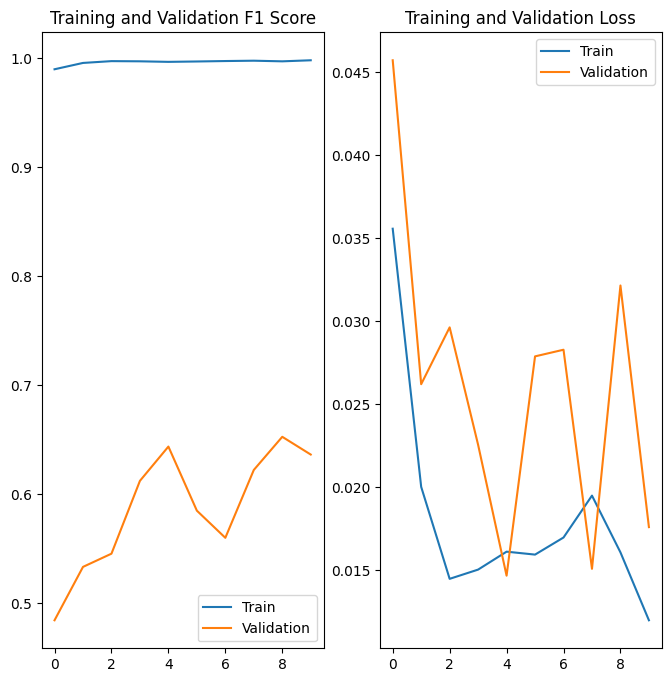

In [28]:
f1_score = history.history['f1_score']
val_f1_score = history.history['val_f1_score']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(len(f1_score)), f1_score, label='Train')
plt.plot(range(len(f1_score)), val_f1_score, label='Validation')
plt.legend(loc='lower right')
plt.title('Training and Validation F1 Score')

plt.subplot(1, 2, 2)
plt.plot(range(len(f1_score)), loss, label='Train')
plt.plot(range(len(f1_score)), val_loss, label='Validation')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

> The **Predict** function takes in input an array of data and returns the predictions relative to that array. The values of predictions array are between 0 and 1.

In [29]:
def Predict(array):
    predictions = model.predict(array)
    predictions = np.squeeze(predictions)
    return predictions

> The **Approximation** function takes in input the array of predictions generated by the model.predict function and approximate according to the *t_cut* value chosen. *t_cut* can vary, depending if we want to improve the purity or the efficiency of the classification.

In [30]:
def Approximation(pred_array, t_cut):
    predictions_approx = []
    for value in pred_array:
        if value >= t_cut:
            value_approx = 1
        if value < t_cut:
            value_approx = 0
        predictions_approx.append(value_approx)
    predictions_approx = np.asarray(predictions_approx)
    return predictions_approx

> TEST DATASET RESULTS

322/322 [==============================] - 1s 4ms/step
[[10245     2]
 [   12    18]]
f1:  0.7200000000000001
precision:  0.9
recall:  0.6


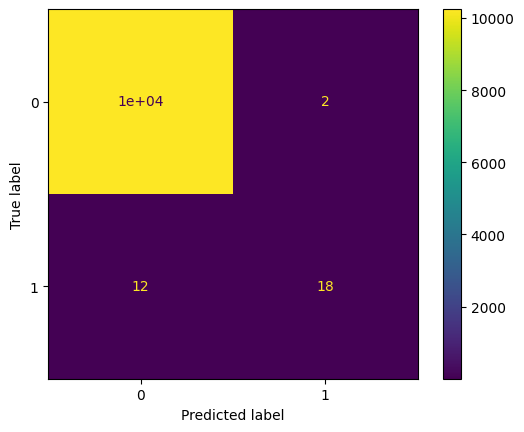

In [31]:
predictions_test = Predict(test_ds)
predictions_test_approx = Approximation(predictions_test, 0.5)
cm_test = metrics.confusion_matrix(test_labels, predictions_test_approx)
F1 = metrics.f1_score(test_labels, predictions_test_approx, average = 'binary')
precision = metrics.precision_score(test_labels, predictions_test_approx, average = 'binary')
recall = metrics.recall_score(test_labels, predictions_test_approx, average = 'binary')
print(cm_test)
print("f1: ", F1)
print("precision: ", precision)
print("recall: ",recall)
cm_display = metrics.ConfusionMatrixDisplay(cm_test).plot()

In [32]:
tp = []
fp = []
fn = []
tn = []

for i in range(len(test_ds)):
    if test_labels[i] == 1 and predictions_test_approx[i] == 1:
        tp.append(i)

for i in range(len(test_ds)):
    if test_labels[i] == 0 and predictions_test_approx[i] == 1:
        fp.append(i)

for i in range(len(test_ds)):
    if test_labels[i] == 1 and predictions_test_approx[i] == 0:
        fn.append(i)

for i in range(len(test_ds)):
    if test_labels[i] == 0 and predictions_test_approx[i] == 0:
        tn.append(i)

> This piece of code prints all the results and the features of the dataset and of the model (defined in **InitializeDatasetParameters** and **InitializeCNNParameters**) into a file called *cnn_results.txt*. It accomplish so by changing the standard output from the original to this created file.

In [36]:
import sys

original_stdout = sys.stdout

with open('./cnn_results.txt', 'a') as f:
    sys.stdout = f 
    model.summary()
    print(InitializeDatasetParameters())
    print(InitializeCNNParameters())
    print('Confusion matrix: ', cm_test)
    print("F1 score: ", F1)
    print("Precision: ", precision)
    print("Recall: ", recall)
    sys.stdout = original_stdout 